In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("meteo_data.csv")
df

,SOLAR_RADIATION,PRECIPITATION,WIND_SPEED,LEAF_WETNESS,HC_AIR_TEMPERATURE,HC_RELATIVE_HUMIDITY,DEW_POINT,DATE
0,408.0,0.0,4.7,0.0,21.71,0.0,0.0,2021-05-30 16:00:00
1,320.0,0.0,4.2,0.0,21.58,0.0,0.0,2021-05-30 17:00:00
2,131.0,0.0,4.1,0.0,21.17,0.0,0.0,2021-05-30 18:00:00
3,84.0,0.0,3.6,0.0,20.69,0.0,0.0,2021-05-30 19:00:00
4,15.0,0.0,2.5,0.0,19.74,0.0,0.0,2021-05-30 20:00:00
...,...,...,...,...,...,...,...,...
26260,120.0,1.6,0.0,55.0,17.27,0.0,0.0,2024-05-29 11:00:00
26261,156.0,0.4,0.1,60.0,18.16,0.0,0.0,2024-05-29 12:00:00
26262,235.0,0.0,1.0,60.0,19.54,0.0,0.0,2024-05-29 13:00:00
26263,427.0,0.0,1.3,30.0,20.71,0.0,0.0,2024-05-29 14:00:00


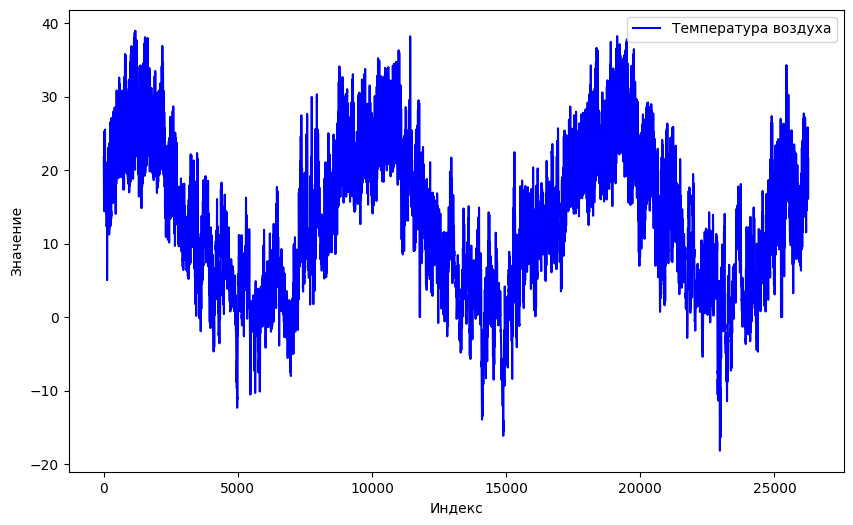

In [5]:
temp = df['HC_AIR_TEMPERATURE']
# Создание массива индексов для оси X
indices = np.arange(len(temp))

plt.figure(figsize=(10, 6))
plt.plot(indices, temp, label='Температура воздуха', color='blue')

# Настройка графика
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()

# Показать график
plt.show()

In [4]:
temp

0        21.71
1        21.58
2        21.17
3        20.69
4        19.74
         ...  
26260    17.27
26261    18.16
26262    19.54
26263    20.71
26264    21.54
Name: HC_AIR_TEMPERATURE, Length: 26265, dtype: float64

In [6]:
avg_temp = []
count = 0
sum_temp = 0
for i in range(len(temp)):
    if count == 24:
        avg_temp.append(sum_temp / 24)
        sum_temp = 0
        count = 0
    else:
        sum_temp += temp[i]
        count += 1

# Добавить последнее среднее значение, если оно не было добавлено
if count != 0:
    avg_temp.append(sum_temp / count)

temp = avg_temp
print(len(avg_temp))

1051


In [7]:
import pandas as pd

# Преобразовать avg_temp в объект DataFrame
avg_temp_df = pd.DataFrame(avg_temp, columns=['HC_AIR_TEMPERATURE'])
#avg_temp_df = avg_temp_df.drop(avg_temp_df.columns[0], axis=1)
avg_temp_df.reset_index(drop=True, inplace=True)
print(avg_temp_df)

      HC_AIR_TEMPERATURE
0              19.422500
1              21.194583
2              19.112500
3              17.168750
4              14.800417
...                  ...
1046           18.188333
1047           15.705417
1048           19.552083
1049           20.083750
1050           18.099333

[1051 rows x 1 columns]


In [8]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [9]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(avg_temp_df, WINDOW_SIZE)
X1.shape, y1.shape

((1046, 5, 1, 1), (1046, 1))

In [10]:
X_train1, y_train1 = X1[:800], y1[:800]
X_val1, y_val1 = X1[800:900], y1[800:900]
X_test1, y_test1 = X1[900:], y1[900:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((800, 5, 1, 1), (800, 1), (100, 5, 1, 1), (100, 1), (146, 5, 1, 1), (146, 1))

In [11]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
cp2 = ModelCheckpoint('model2/model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [18]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp2])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.8504 - root_mean_squared_error: 3.4351 - val_loss: 14.3917 - val_root_mean_squared_error: 3.7919
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4360 - root_mean_squared_error: 3.3806 - val_loss: 14.2809 - val_root_mean_squared_error: 3.7691
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.6248 - root_mean_squared_error: 3.2562 - val_loss: 14.2322 - val_root_mean_squared_error: 3.7580
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8303 - root_mean_squared_error: 3.2885 - val_loss: 14.1600 - val_root_mean_squared_error: 3.7430
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.6905 - root_mean_squared_error: 3.4181 - val_loss: 14.0740 - val_root_mean_squared_error: 3.7234
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4312 - root_mean_squared_error: 3.3798 - val_loss: 14.0110 - val_root_mean_squared_error: 3.7081
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


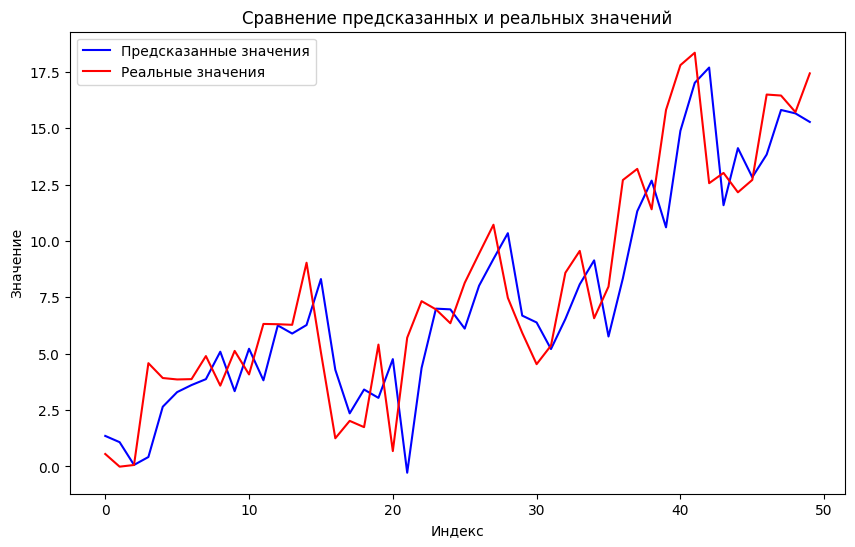

In [19]:
# Предсказание на тестовом наборе данных
y_pred1 = model2.predict(X_test1)

# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred1[50:100], label='Предсказанные значения', color='blue')
plt.plot(y_test1[50:100], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [20]:
# Оценка MAE
mae = mean_absolute_error(y_test1, y_pred1)

# Оценка MSE
mse = mean_squared_error(y_test1, y_pred1)

# Оценка RMSE
rmse = np.sqrt(mse)

# Оценка R^2
r2 = r2_score(y_test1, y_pred1)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)

Средняя абсолютная ошибка (MAE): 2.515206118084796
Средняя квадратичная ошибка (MSE): 12.779941254995256
Корень из среднеквадратичной ошибки (RMSE): 3.5749043700489747
Коэффициент детерминации (R^2): 0.7710929705257864
